# XX - common problems & bad data situations
In this notebook, we will revise common problems that might come up when dealing with real-world data. Most problems arrise from bad sampling combined with a poor discretization. For estimating a Markov model, it is required to have a connected data set, i.e. we must have observed each process in both directions. PyEMMA checks if this requirement is fulfilled, however in certain situations this might be less obvious.  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyemma.datasets
import numpy as np
#import mdshare
import pyemma

## Case 1: preprocessed, two-dimensional data (toy model)
### well-sampled double-well potential
Let's again have a look at the double-well potential. Since we are only interested in the problematic situations here, we will simplify our data a bit and work with a 1D TICA projection.

In [2]:
file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']
trjs = pyemma.coordinates.tica(data).get_output()

In [4]:
def plot_1D_histogram_trajectories(trjs, cl=None, max_traj_length=200, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    for n, _traj in enumerate(trjs):
        ax.hist(_traj, bins=30, alpha=.33, density=True, color='C{}'.format(n));
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    for n, _traj in enumerate(trjs):
        ax.plot(_traj[:min(len(_traj), max_traj_length)], 
                np.linspace(*ylims, min(len(_traj), max_traj_length)), 
                alpha=.6, color='C{}'.format(n), label='traj {}'.format(n))
        if cl is not None:
            ax.plot(cl.clustercenters[cl.dtrajs[n][:min(len(_traj), max_traj_length)], 0], 
                    np.linspace(*ylims, min(len(_traj), max_traj_length)), 
                    '.-', alpha=.6, label='dtraj {}'.format(n), linewidth=.3)
    ax.annotate('$x(time)$', xy=(.75 * xlims[1], .7 * ylims[1]), xytext=(.75 * xlims[1], .3 * ylims[1]),
        arrowprops=dict(fc='C0', ec='None', alpha=.6, width=2))
    ax.set_xlabel('TICA coordinate')
    ax.set_ylabel('histogram counts & trajecotory time')
    ax.legend(loc=2)

HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

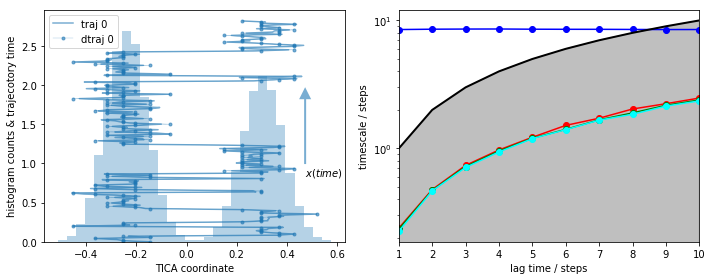

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

cl = pyemma.coordinates.cluster_regspace(trjs, dmin=.05)

plot_1D_histogram_trajectories(trjs, cl=cl, ax=ax[0])

lags = [i + 1 for i in range(10)]
its = pyemma.msm.its(cl.dtrajs, lags=lags)
pyemma.plots.plot_implied_timescales(its, marker='o', ax=ax[1], nits=4)
fig.tight_layout()

We see a nice, reversibly connected trajectory. That means we have sampled transitions between the basins in both directions and are resolved by the discritization. As we see from the almost perfect overlay of discrete and contineous trajectory, nearly no discritization error is made. 

###  irreversibly connected double-well trajectories
In MD simulations, we often face the problem that a process is sampled only in one direction. For example, consider protein-protein binding. The unbinding might take on the order of seconds to minutes and is thus difficult to sample. We will have a look what happens with the MSM in this case. 

Our example are two trajectories sampled from a double-well potential. They will be color coded.

In [2]:
#file = mdshare.fetch('doublewell_oneway.npy', working_directory='data')
file = 'data/doublewell_oneway.npy'
trjs = [trj for trj in np.load(file)]

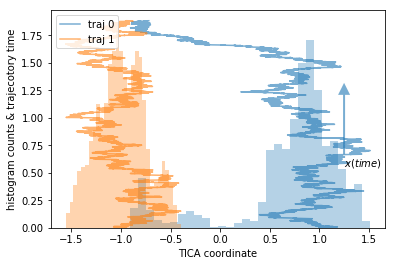

In [5]:
plot_1D_histogram_trajectories(trjs, max_traj_length=trjs[0].shape[0])

We note that the orange trajectory does not leave its potential well while the blue trajectory does a transition to the other well. Thus, even though we have one transition, we do not sample the way out of one of the potential wells, thus effectively sampling a sink state. Let's have a look at the MSM. Since in higher dimensions, we often face the problem of a poor discretization, we will simulate this situation by using too few cluster centers.

In [6]:
cl_fine = pyemma.coordinates.cluster_regspace(trjs, dmin=.1)
cl_bad = pyemma.coordinates.cluster_regspace(trjs, dmin=.7)
print(cl_fine.n_clusters, cl_bad.n_clusters)

HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=8), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=8), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

04-06-18 11:57:47 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[158] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


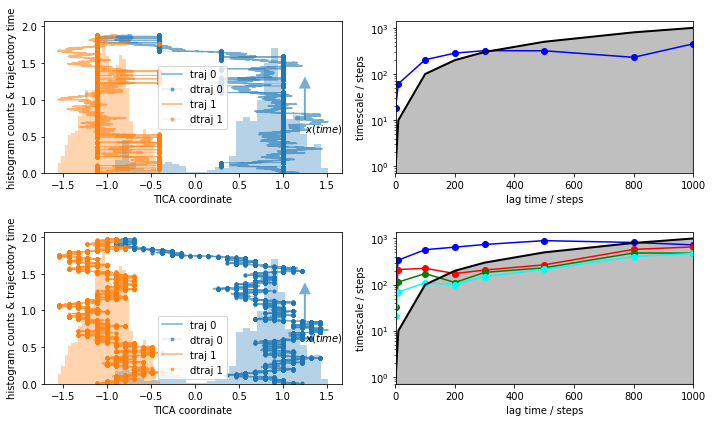

In [207]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey='col')

for cl, ax in zip([cl_bad, cl_fine], axes):

    plot_1D_histogram_trajectories(trjs, cl=cl, max_traj_length=trjs[0].shape[0], ax=ax[0])

    its = pyemma.msm.its(cl.dtrajs, lags=[1, 10, 100, 200, 300, 500, 800, 1000])
    pyemma.plots.plot_implied_timescales(its, marker='o', ax=ax[1], nits=4)

fig.tight_layout()

#### What do we see? 

1) We observe implied timescales that even look converged in the fine sampling case. 

2) With poor sampling, the process cannot be resolved any more i.e. the ITS does not convergence before the lag time exceeds the implied time scale. 

The obvious question is, what is the process that can be observed in the fine discritization case? PyEMMA checks for disconnectivity and thus should not find the process between the two wells. We follow this question by taking a look at the first eigenvector, which corresponds to that process.

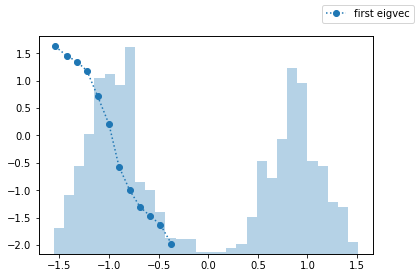

In [209]:
m = pyemma.msm.estimate_markov_model(cl_fine.dtrajs, 200)
fig, ax = plt.subplots(1,1)
ax.plot(cl_fine.clustercenters[m.active_set, 0], m.eigenvectors_right()[:, 1], 'o:', label='first eigvec')
tx = ax.twinx()
tx.hist(np.concatenate(trjs), bins=30, alpha=.33)
tx.set_yticklabels([]); tx.set_yticks([])
fig.legend()

We observe a process which is entirely taking place in the left potential well. How come? PyEMMA estimates Markov models only on the largest connected set, as MSMs are only defined here. In this particular example, the largest connected set is the microstates in the left potential well. That means that we find a transition between the right and the left side of this well. This is not wrong, it might just be non-informative or irrelevant. 

The set of microstates which is used for the MSM estimation is stored in the MSM python object and can be retrieved via `.active_set`. In this example we clearly see that some states are missing.

In [210]:
m.active_set

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

### disconnected double-well trajectories with cross-overs
This example covers the worst-case scenario. We have two trajectories that live in two separated wells and never transition to the other one. Due to a very bad clustering, we believe that the data is connected. This can happen if we cluster a large dataset in very high dimensions where it is especially difficult to debug. 

In [2]:
#file = mdshare.fetch('doublewell_oneway.npy', working_directory='data')
file = 'data/doublewell_disconnected.npy'
trjs = [trj for trj in np.load(file)]

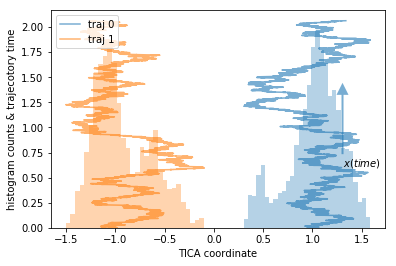

In [5]:
plot_1D_histogram_trajectories(trjs, max_traj_length=trjs[0].shape[0])

In [6]:
cl_fine = pyemma.coordinates.cluster_regspace(trjs, dmin=.1)
cl_bad = pyemma.coordinates.cluster_regspace(trjs, dmin=.7)
print(cl_fine.n_clusters, cl_bad.n_clusters)

25 3


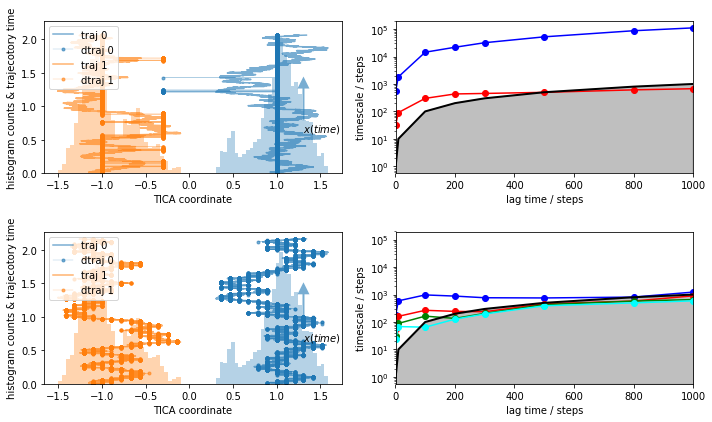

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey='col')

for cl, ax in zip([cl_bad, cl_fine], axes):

    plot_1D_histogram_trajectories(trjs, cl=cl, max_traj_length=trjs[0].shape[0], ax=ax[0])

    its = pyemma.msm.its(cl.dtrajs, lags=[1, 10, 100, 200, 300, 500, 800, 1000])
    pyemma.plots.plot_implied_timescales(its, marker='o', ax=ax[1], nits=4)

fig.tight_layout()

#### What do we see?

1) With the fine discretization, we observe some timescales that are converged. These are most probably processes within one of the wells as we say previously.

2) The poor discretization introduces a large error and discribes short visits to the other basin.

3) The timescales in the poor discritization are much higher but not converged. 

The reason for the high timescales of the poor discretization are in fact the artificial cross-over events created by the poor discritization. This process was not actually sampled and is an artifact of bad clustering. Let's look at it in more detail anyway and even compute metastable states with a PCCA.

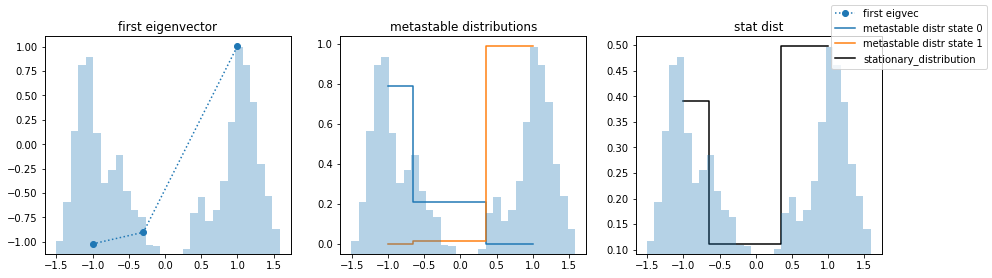

In [8]:
m = pyemma.msm.estimate_markov_model(cl_bad.dtrajs, 200)
m.pcca(2)
index_order = np.argsort(cl_bad.clustercenters[:, 0])

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].plot(cl_bad.clustercenters[index_order, 0], m.eigenvectors_right()[index_order, 1], 'o:', label='first eigvec')
ax[0].set_title('first eigenvector')

for n, metastable_distribution in enumerate(m.metastable_distributions):
    ax[1].step(cl_bad.clustercenters[index_order, 0], metastable_distribution[index_order], ':', 
               label='metastable distr state {}'.format(n), where='mid')
ax[1].set_title('metastable distributions')
ax[2].step(cl_bad.clustercenters[index_order, 0], m.pi[index_order], 'k--', label='stationary_distribution', where='mid')
ax[2].set_title('stat dist')

for _ax in ax:
    tx = _ax.twinx()
    tx.hist(np.concatenate(trjs), bins=30, alpha=.33)
    tx.set_yticklabels([]); tx.set_yticks([])

fig.legend()

We observe that the first eigenvector represents a process that does not exist, i.e. is an artifact. Nevertheless, the PCCA+ algorithm can separate metastable states in a way we would expect. It finds the two disconnected states. However, the stationary distribution yields arbitrary results. 

#### How to detect disconnectivity?
Generally, hidden Markov models (HMMs) are much more reliable because they come with an additional layer of hidden states. Cross-over events are thus unlikely to be counted as "real" transitions. Thus, it is a good idea to estimate an HMM.

04-06-18 14:32:10 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[7] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


/storage/mi/thempel/anaconda3/envs/adaptivemd/lib/python3.6/site-packages/msmtools/analysis/dense/decomposition.py:545: SpectralWarning: Multiple eigenvalues with magnitude one.
  warnings.warn('Multiple eigenvalues with magnitude one.', SpectralWarning)
/storage/mi/thempel/anaconda3/envs/adaptivemd/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


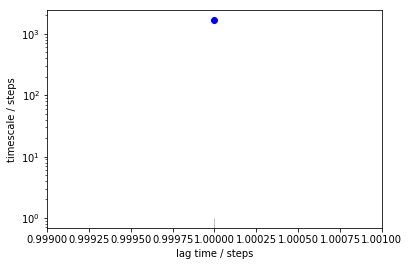

In [9]:
its = pyemma.msm.timescales_hmsm(cl_bad.dtrajs, 2, lags=[1, 10, 100, 200, 300, 500, 800, 1000])
pyemma.plots.plot_implied_timescales(its, marker='o', ylog=True)

As we see, most of the requested timescales could not be computed because the underlying HMM is disconnected (a.k.a. there are multiple eigenvalues with magnitude one). What happens if we take our previously estimated MSM and coarse grain it into two states with the HMM method?

## TODO: something wrong with pyEMMA behavior. #1312.

In [10]:
hmm = m.coarse_grain(2)
print('Implied timescale: ', hmm.timescales())

Implied timescale:  [ inf]


/storage/mi/thempel/anaconda3/envs/adaptivemd/lib/python3.6/site-packages/msmtools/analysis/dense/decomposition.py:545: SpectralWarning: Multiple eigenvalues with magnitude one.
  warnings.warn('Multiple eigenvalues with magnitude one.', SpectralWarning)


We are getting an implied timescale which is infinity. This in a sense corresponds to the original, unconverged MSM time scale displayed above. The HMM captures the value that was underestimated by the MSM. Let's compare this to the fine state space discretization by estimating a new HMM.

What does this mean? The HMM estimates that the state does not decay, i.e. the time it takes to fall back to the equilibrium distribution is infinity. This means that the disconnectivity has been detected.

In [11]:
m = pyemma.msm.estimate_markov_model(cl_fine.dtrajs, 200)

In [74]:
hmm_finediscretization = pyemma.msm.estimate_hidden_markov_model(cl_fine.dtrajs, 2, 200)
print('Implied timescale: ', hmm.timescales())

Implied timescale:  [ inf]


/storage/mi/thempel/anaconda3/envs/adaptivemd/lib/python3.6/site-packages/msmtools/analysis/dense/decomposition.py:545: SpectralWarning: Multiple eigenvalues with magnitude one.
  warnings.warn('Multiple eigenvalues with magnitude one.', SpectralWarning)


We see that still that the implied time scale is infinity. That means that the effect of the bad discretization on the HMM estimation is not visible in this example. We find that the metastable distribution is similar to the one estimated by PCCA+ and separates the two potential wells independently of the quality of the discretization.

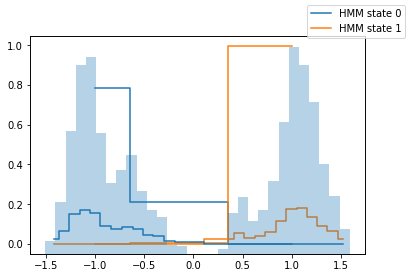

In [18]:
fig, ax = plt.subplots(1, 1)
index_order = np.argsort(cl_bad.clustercenters[:, 0])
for n, metastable_distribution in enumerate(hmm.metastable_distributions):
    ax.step(cl_bad.clustercenters[index_order, 0], metastable_distribution[index_order], ':', 
               where='mid', color='C'+str(n), label='HMM state '+str(n))
index_order = np.argsort(cl_fine.clustercenters[:, 0])
for n, metastable_distribution in enumerate(hmm_finediscretization.metastable_distributions):
    ax.step(cl_fine.clustercenters[index_order, 0], metastable_distribution[index_order], ':', 
               where='mid', color='C'+str(1-n))
tx = ax.twinx()
tx.hist(np.concatenate(trjs), bins=30, alpha=.33)
tx.set_yticklabels([]); tx.set_yticks([])
fig.legend()

Please note that the metastable state number is arbitrary.

## Case 2: low-dimensional molecular dynamics data (alanine dipeptide)
In this example, we will show how an ill-conducted TICA analysis can yield results that look metastable in the 2D histogram, but in fact are not describing the slow dynamics. Please note that this was deliberately broken with a non-sensical TICA-lagtime of almost trajectory length, which is 250 ns.

We start off with adding all atom coordinates. That's a non-optimal choice because it artificially blows up the dimensionality, but might still a reasonable choice depending on the problem. A well-conducted TICA projection can extract the slow coordinates, as we will see at the end of this example.

In [432]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.dcd', working_directory='data')
feat = pyemma.coordinates.featurizer(pdb)

feat.add_all()
data = pyemma.coordinates.load(files, features=feat)

TICA analysis is conducted with an extremely high lag time of almost 249.9 ns. We map down to two dimensions.

In [433]:
tica = pyemma.coordinates.tica(data, lag=data[0].shape[0]-100, dim=2)
inp = tica.get_output()

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f326d8adf98>)

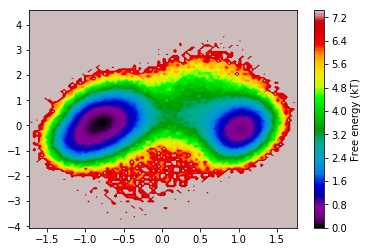

In [434]:
pyemma.plots.plot_free_energy(*np.concatenate(inp).T)

In the free energy plot, we recognice two defined basins that are nicely separated by the first TIC. We thus continue with a discretization of this space and estimate MSM implied timescales.

In [435]:
clustering = pyemma.coordinates.cluster_kmeans(inp, k=200, max_iter=30, stride=100)

05-06-18 10:38:44 pyemma.coordinates.clustering.kmeans.KmeansClustering[202] INFO     Cluster centers converged after 13 steps.


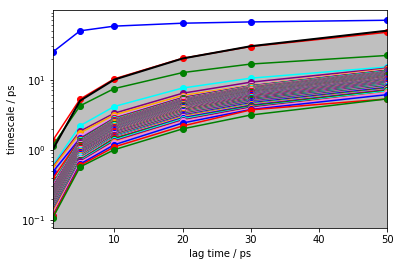

In [436]:
its = pyemma.msm.its(clustering.dtrajs, lags=[1, 5, 10, 20, 30, 50])
pyemma.plots.plot_implied_timescales(its, marker='o', units='ps')

Indeed, we observe a converged timescale. In this example we already know that it is way lower than expected, but in the general case we are unaware of the real dynamics of the system. Thus, we estimate an MSM at lag time 20. Coarse graining and validation will be donw with 2 metastable states since we found 2 basins in the free energy landscape and have one slow process in the ITS plot.

In [437]:
msm = pyemma.msm.estimate_markov_model(clustering.dtrajs, 20)
msm.pcca(2);

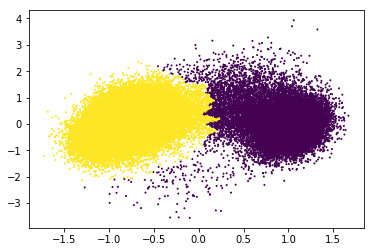

In [438]:
stride = 10
metastable_trajs_strided = [msm.metastable_assignments[dtrj[::stride]] for dtrj in clustering.dtrajs]
tica_trajs_strided = [i[::stride] for i in inp]
plt.scatter(*np.concatenate(tica_trajs_strided).T, s=1, c=np.concatenate(metastable_trajs_strided))

As we see, the PCCA+ algorithm is perfectly able to separate the two basins. Let's go on with a Chapman-Kolmogorow validation.

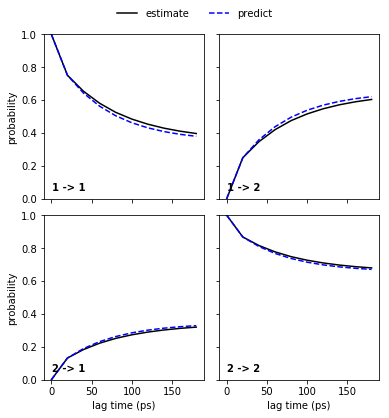

In [439]:
pyemma.plots.plot_cktest(msm.cktest(2), units='ps');

Congratulations, we have estimated a well-validated Markov model. The only question remaining is: What does it actually describe? For this, we usually extract representative structures as described in a previous notebook. 

#### What could be wrong about it?
Let's have a look at the trajectories as assigned to PCCA coarse states. We have already computed them before but not looked at their time dependence.

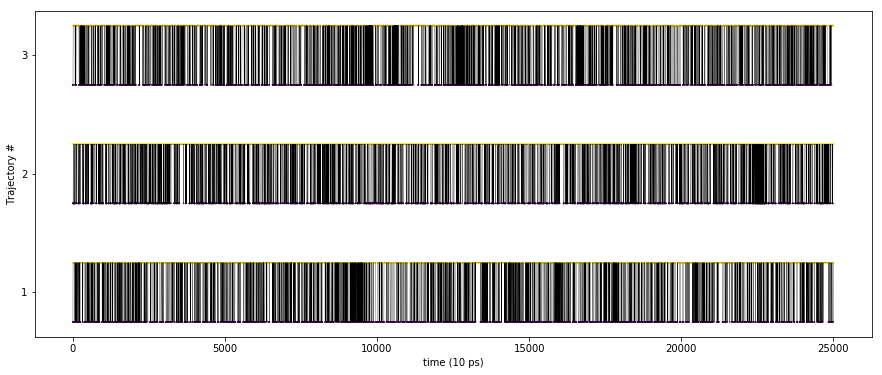

In [440]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), sharey=True, sharex=True)
ax_yticks_labels = []
for n, pcca_traj in enumerate(metastable_trajs_strided):
    ax.plot(range(len(pcca_traj)), msm.n_metastable * n + pcca_traj, color='k', linewidth=.3)
    ax.scatter(range(len(pcca_traj)), msm.n_metastable * n + pcca_traj, c=pcca_traj, s=.1)
    ax_yticks_labels.append(((msm.n_metastable * (2*n+1) - 1)/2, n+1))
ax.set_yticks([l[0] for l in ax_yticks_labels])
ax.set_yticklabels([str(l[1]) for l in ax_yticks_labels])
ax.set_ylabel('Trajectory #')
ax.set_xlabel('time ({} ps)'.format(stride));

#### What do we see?
The above figure shows the metastable states visited by the trajectory over time. Each metastable state is color-coded, the trajectory is shown by the black line. This is clearly not a metastable trajectory as we would have expected. What did we do wrong? Let's have a look at the TICA trajectories, not only the histogram!

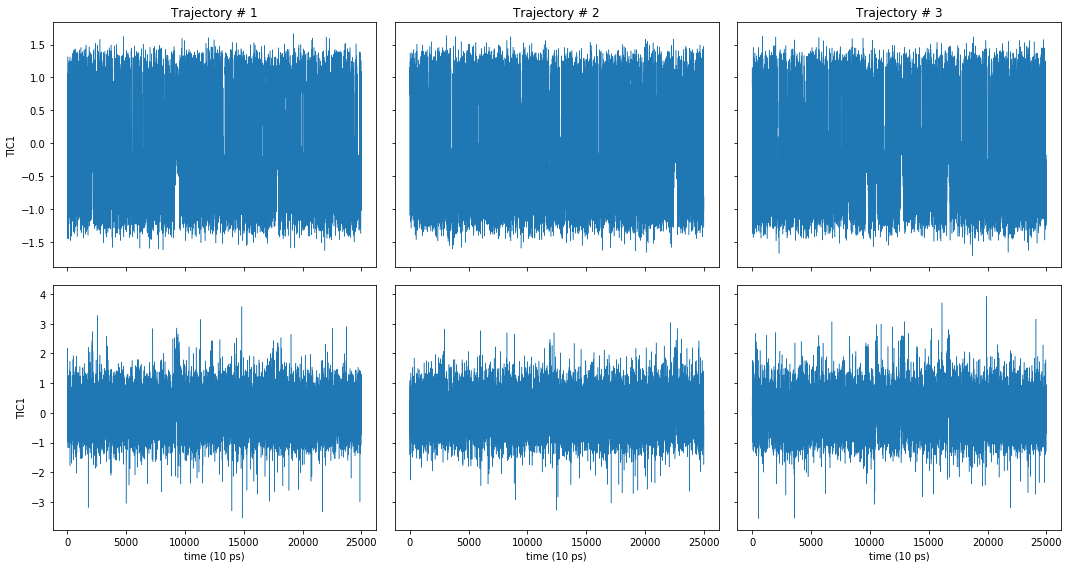

In [398]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey='row')

for n, trj in enumerate(inp):
    for dim, traj1d in enumerate(trj.T):
        ax[dim][n].plot(traj1d[::stride], linewidth=.5)
for _ax in ax[1]: _ax.set_xlabel('time ({} ps)'.format(stride))
for _ax in ax[:, 0]: _ax.set_ylabel('TIC{}'.format(dim))
for n, _ax in enumerate(ax[0]): _ax.set_title('Trajectory # {}'.format(n+1))
fig.tight_layout()

#### What do we see?
This is essentially noise, so it is not suprising that the metastable trajectories do not show significant metastability. The MSM nevertheless found a process in the above TICs, which however does not seem to describe any of the slow dynamics. Thus, the model is not wrong, it is just un-informative. 

As we see in this example, it can be instructive to keep the trajectories in mind and not to rely on the histograms alone. Histograms are no proof of metastability, they can only give us a hint towards defined states in a multi-dimensional state space which can be metastable.

#### How to fix it?
In this particular example, we already know the issue: The TICA lag time was deliberately chosen way too high. That's easy to fix.

Let's now have a look at how the metastable trajectories should look like for a decent model such as the one estimated in the previous notebooks. We will take the same input data, do a TICA transform with a realistic lag time of 10 ps and coarse grain into 2 metastable states in order to compare with the example above.

In [442]:
tica = pyemma.coordinates.tica(data, lag=10, dim=2)
inp = tica.get_output()
clustering = pyemma.coordinates.cluster_kmeans(inp, k=200, max_iter=30, stride=100)

05-06-18 10:41:55 pyemma.coordinates.clustering.kmeans.KmeansClustering[209] INFO     Cluster centers converged after 3 steps.


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f326c5873c8>)

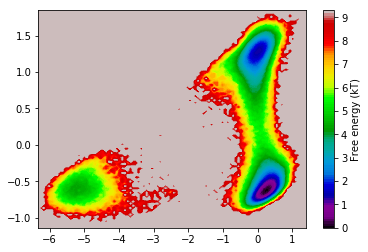

In [443]:
pyemma.plots.plot_free_energy(*np.concatenate(inp).T)

In [444]:
msm = pyemma.msm.estimate_markov_model(clustering.dtrajs, lag=20)
msm.pcca(2);

In [445]:
metastable_trajs_strided = [msm.metastable_assignments[dtrj[::stride]] for dtrj in clustering.dtrajs]

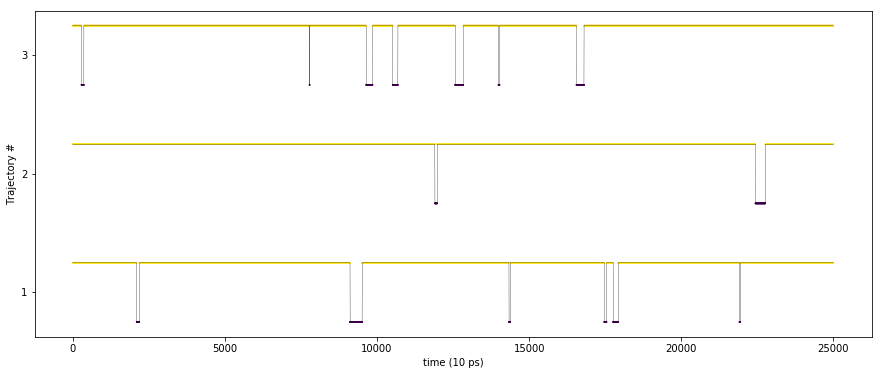

In [446]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), sharey=True, sharex=True)
ax_yticks_labels = []
for n, pcca_traj in enumerate(metastable_trajs_strided):
    ax.plot(range(len(pcca_traj)), M.n_metastable * n + pcca_traj, color='k', linewidth=.3)
    ax.scatter(range(len(pcca_traj)), M.n_metastable * n + pcca_traj, c=pcca_traj, s=.1)
    ax_yticks_labels.append(((M.n_metastable * (2*n+1) - 1)/2, n+1))
ax.set_yticks([l[0] for l in ax_yticks_labels])
ax.set_yticklabels([str(l[1]) for l in ax_yticks_labels])
ax.set_ylabel('Trajectory #')
ax.set_xlabel('time ({} ps)'.format(stride));

## Wrapping up
In this notebook, we have learned about some problems that can arrise when estimating MSMs with "real world" data. In detail, we have seen

- irreversibly connected dynamics
- fully disconnected trajectories
- ill-conducted TICA analysis

and how to identify them. The most important message from this tutorial is that histograms are not a means of identifying metastability or connectedness. One should not forgot about the underlying trajectories, that are the ground truth to be modeled. Histograms only help us to understand this ground truth but are not necessarily meaningful.